# **E-Commerce Product Categorization**

# Table of content

1. [Import Libraries](#import-libraries)
2. [Data Preparation](#data-preparation)
3. [Exploratory Data Analysis (EDA)](#eda)
   - [3.1 Product Distribution](#31-product-distribution)
   - [3.2 Description Lengths](#32-description-lengths)
4. [Data Normalization](#data-normalization)
   - [4.1 Text Cleaning Function](#41-text-cleaning-function)
   - [4.2 Stop Words Removal Function](#42-stop-words-removal-function)
   - [4.3 Lemmatization Function](#43-lemmatization-function)
   - [4.4 Part of Speech Selection Function](#44-part-of-speech-selection-function)
   - [4.5 Text Normalization Function](#45-text-normalization-function)
5. [Train Test Split](#train-test-split)
6. [TF-IDF Vectorization](#tf-idf-vectorization)
7. [Baseline Models Training](#baseline-models-training)
8. [Hyperparameter Tuning](#hyperparameter-tuning)

# 1. Import Libraries


In [234]:
#import the library
import numpy as np
import pandas as pd
import re

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
import spacy
from nltk.stem import PorterStemmer
from nltk import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import logging
import time
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manoj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\manoj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\manoj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 2. Data Preparation

In [235]:
train_product_df = pd.read_csv(r'datasets\train_product_data.csv') # Historical data
test_product_df = pd.read_csv(r'datasets\test_data.csv') # unseen data 

In [236]:
train_product_df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,Footwear,SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
2,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."


In [237]:
train_product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  14999 non-null  object 
 1   crawl_timestamp          14999 non-null  object 
 2   product_url              14999 non-null  object 
 3   product_name             14999 non-null  object 
 4   product_category_tree    14999 non-null  object 
 5   pid                      14999 non-null  object 
 6   retail_price             14942 non-null  float64
 7   discounted_price         14942 non-null  float64
 8   image                    14996 non-null  object 
 9   is_FK_Advantage_product  14999 non-null  bool   
 10  description              14998 non-null  object 
 11  product_rating           14999 non-null  object 
 12  overall_rating           14999 non-null  object 
 13  brand                    10289 non-null  object 
 14  product_specifications

In [238]:
train_product_df.isnull().sum()

uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 57
discounted_price             57
image                         3
is_FK_Advantage_product       0
description                   1
product_rating                0
overall_rating                0
brand                      4710
product_specifications        6
dtype: int64

In [239]:
# handling null values
train_product_df.dropna(axis=0 ,subset=['description'], inplace=True)

In [240]:
# checking duplicates
train_product_df.duplicated(subset=['description']).sum()

1835

In [241]:
# Drop duplicates
train_product_df.drop_duplicates(subset=['description'], inplace=True)
train_product_df.duplicated(subset=['description']).sum()

In [243]:
train_df = train_product_df[['description', 'product_category_tree']]

In [244]:
train_df.shape

(13163, 2)

# 3. EDA

In [245]:
train_df.head()

,description,product_category_tree
0,Key Features of Alisha Solid Women's Cycling S...,Clothing
1,Key Features of AW Bellies Sandals Wedges Heel...,Footwear
2,Key Features of Alisha Solid Women's Cycling S...,Clothing
3,Key Features of Alisha Solid Women's Cycling S...,Clothing
4,"Key Features of dilli bazaaar Bellies, Corpora...",Footwear


In [246]:
# list of products
train_df.product_category_tree.unique()

array(['Clothing ', 'Footwear ', 'Pens & Stationery ',
       'Bags, Wallets & Belts ', 'Home Decor & Festive Needs ',
       'Automotive ', 'Tools & Hardware ', 'Baby Care ',
       'Mobiles & Accessories ', 'Watches ', 'Toys & School Supplies ',
       'Jewellery ', 'Kitchen & Dining ', 'Computers '], dtype=object)

## 3.1 Product distribution

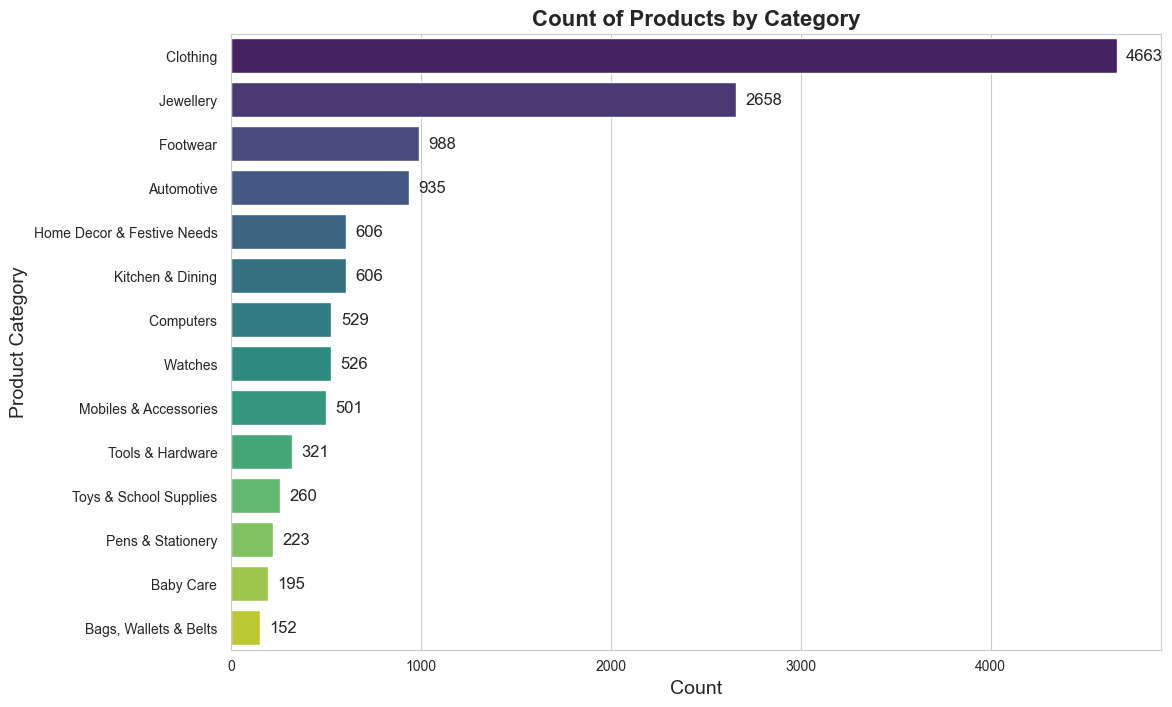

In [247]:

# Create a category count DataFrame from the Series for better handling
category_dist = train_df.product_category_tree.value_counts().reset_index()
category_dist.columns = ['Product Category', 'Count']

# Set the style of the plot
sns.set_style("whitegrid")

# Create a count plot with swapped axes
plt.figure(figsize=(12, 8))
palette = sns.color_palette("viridis", len(category_dist))  #  color palette 
sns.barplot(x='Count', y='Product Category', data=category_dist, palette=palette)

# Adding labels and title
plt.ylabel('Product Category', fontsize=14)
plt.xlabel('Count', fontsize=14)
plt.title('Count of Products by Category', fontsize=16, fontweight='bold')

# Adding value annotations on the bars
for index, value in enumerate(category_dist['Count']):
    plt.text(value + 50, index, str(value), va='center', fontsize=12)

# Show the plot
plt.show()

## 3.2 Description lengths

In [248]:
# Calulating mean Description length
train_df['length'] =  train_df['description'].apply(lambda x: len(x.split(' ')))
train_df['length'].mean().round()

70.0

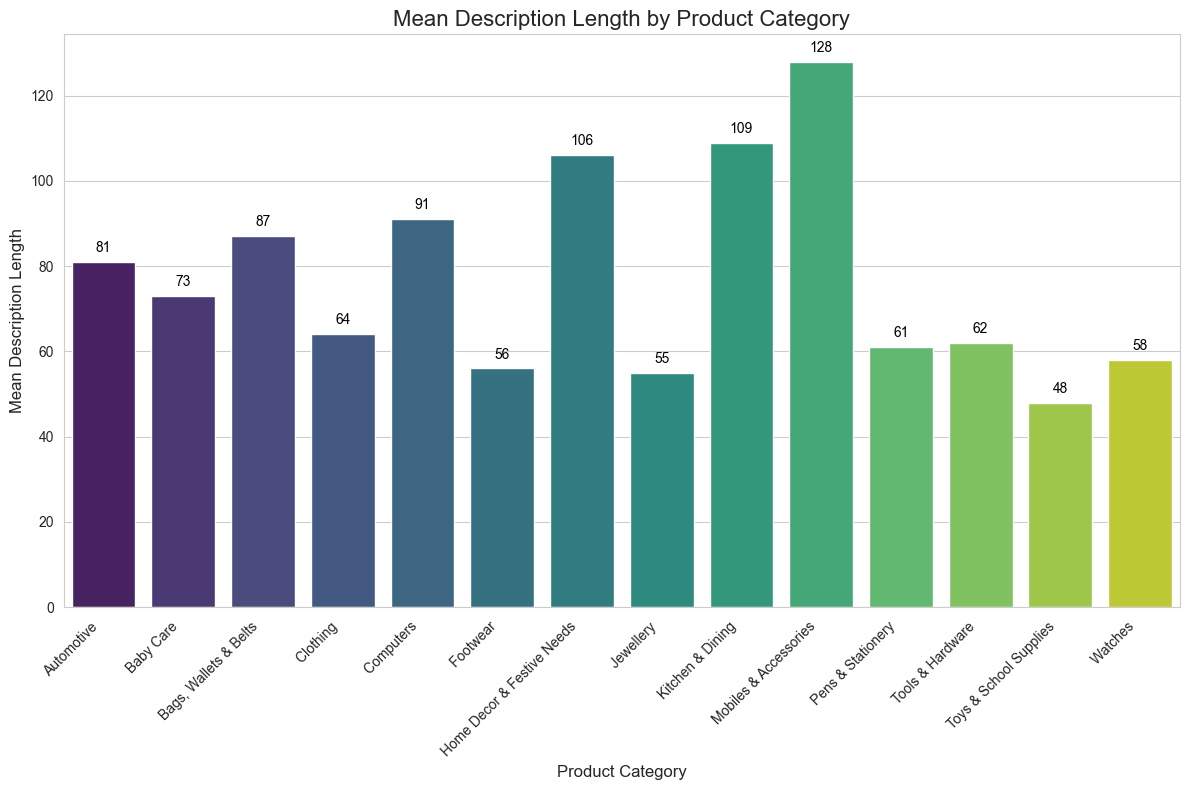

In [279]:
# Group by product_category_tree and calculate the mean length
mean_length_by_category = train_df.groupby('product_category_tree')['length'].mean().reset_index()

# Round the mean lengths
mean_length_by_category['length'] = mean_length_by_category['length'].round()

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a bar chart
bar_plot = sns.barplot(data=mean_length_by_category, x='product_category_tree', y='length', palette='viridis')

# Customize the plot
plt.title('Mean Description Length by Product Category', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Mean Description Length', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Annotate the bars with mean length values
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=10, color='black', 
                      xytext=(0, 5),  # offset text by 5 points vertically
                      textcoords='offset points')

plt.tight_layout()  # Adjust layout

# Show the plot
plt.show()

mobile  & Accessories, Home Decor & Festive Needs, Kitchen & Dining   seem to have high description then the rest. 

# 4. Data Normalization

## 4.1 Text Cleaning Function

In [250]:
# Helper function for cleaning text and removing other irrelevant data

def clean_text(description):

    #lowercase the description
    description=description.lower()

    # Remove URLs that end with .com
    description = re.sub(r'\S+\.com', '', description)

    #remove the @mention
    description = re.sub("@[A-Za-z0-9_]+","", description)

    #remove the hashtags
    description = re.sub("#[A-Za-z0-9_]+","", description)

    #remove any links 
    description = re.sub(r"http\S+", "", description)
    description = re.sub(r"www.\S+", "", description)

    #remove punctuation 
    description = re.sub('[()!?]', ' ', description)
    description = re.sub('\[.*?\]',' ', description)

    #remove non alphabetic words 
    description = re.sub("[^a-z]"," ", description)

    # return description without unnecessary whitespace
    return description.strip()


## 4.2 Stop words removal function

In [251]:
# Making list for relevant  stopwords

# Stopwords and common words
stops = set(stopwords.words("english"))  
alphabets = set("abcdefghijklmnopqrstuvwxyz")

# Prepositions
prepositions = set([
    "about", "above", "across", "after", "against", "among", "around", "at",
    "before", "behind", "below", "beside", "between", "by", "down", "during",
    "for", "from", "in", "inside", "into", "near", "of", "off", "on", "out",
    "over", "through", "to", "toward", "under", "up", "with", "aboard", "along",
    "amid", "as", "beneath", "beyond", "but", "concerning", "considering",
    "despite", "except", "following", "like", "minus", "onto", "outside", "per",
    "plus", "regarding", "round", "since", "than", "till", "underneath", "unlike",
    "until", "upon", "versus", "via", "within", "without"
])

# Conjunctions
conjunctions = set([
    "and", "but", "for", "nor", "or", "so", "yet",
    "both", "either", "neither", "not", "only", "whether"
])

# Other words and additional stopwords
others = set([
    "ã", "å", "ì", "û", "ûªm", "ûó", "ûò", "ìñ", "ûªre", "ûªve", "ûª", 
    "ûªs", "ûówe", "among", "get", "onto", "shall", "thrice", 
    "thus", "twice", "unto", "us", "would", "rs"
])

# Common ecommerce words
common_ecommerce_words = set([
    "shop", "shopping", "buy", "genuine", "product", "store", "day", "replacement",
    "good", "description", "purchase", "checkout", "cart", "details", "discount",
    "offer", "deal", "sale", "item", "voucher", "coupon", "promo", "promotion",
    "buying", "selling", "seller", "buyer", "payment", "free", "order", "returns",
    "exchange", "refund", "customer", "service", "support", "review", "rating",
    "online", "offline", "delivery", "shipping", "track", "cash", "prices", 
    "transaction", "secure", "feature", "guarantee", "fast", "easy", "reliable",
    "safe", "doorstep", "discounted", "affordable", "cheap", "quality", "brand",
    "stock", "new", "latest", "trending", "hot", "exclusive"
])

# Ecommerce platform names
ecommerce_platforms = set(["flipkart", "amazon", "mintra", "snapdeal"])

# Combine all stopwords ensuring no overlap
all_stopwords = stops | alphabets | prepositions | conjunctions | others | common_ecommerce_words | ecommerce_platforms



In [252]:
# stopwords removal function

def remove_stops(description):
    description = ' '.join([word for word in description.split() if word not in (all_stopwords)])
    return description.strip()


## 4.3 Lemmatization function

In [253]:
# Stemming or Lemmatization

# Stemming
stemmer = PorterStemmer()
def text_stemmer(description):
    stemmed_words = " ".join([stemmer.stem(word) for word in description.split()])
    return stemmed_words

# lemmatization
lemmatizer = spacy.load("en_core_web_sm", disable = ['parser', 'ner']) # using spacy lemmatization for high accuracy and speed

def text_lemmatizer(description):
    lemmatize_words = " ".join([token.lemma_ for token in lemmatizer(description)])
    return lemmatize_words



## 4.4 Part of speech selection function

In [254]:
# keeping relevant part of speech
regexp = RegexpTokenizer(r"[\w']+")

def keep_pos(text):
    # Tokenize and tag POS
    tokens_tagged = pos_tag(regexp.tokenize(text))
    
    # Define POS tags to keep
    keep_tags = {'NN', 'NNS', 'NNP', 'NNPS',  # Nouns
                 'JJ', 'JJR', 'JJS',        # Adjectives
                 'RB', 'RBR', 'RBS',        # Adverbs
                 'VB', 'VBD', 'VBG', 'VBN', # Verbs
                 'FW'}                      # Foreign words
    
    # Filter and join kept words
    return " ".join(word for word, tag in tokens_tagged if tag in keep_tags)

## 4.5 Text Normalization function

In [255]:
# Text normalization
def text_normalization(description):

    description = clean_text(description)
    description = text_lemmatizer(description) # using lemmatizer for high accuracy alternately use stemmer for speed.
    # description = text_stemmer(description)

    description = keep_pos(description)
    description = remove_stops(description)
    return description

In [256]:
# testing normalization function
sample_text ="Introducing our latest smartphone, the TechNova X! 📱 With a sleek design and cutting-edge features, it's perfect for anyone looking to upgrade. Enjoy 128GB of storage, a stunning 6.5-inch display, and a 48MP camera. 🌟 Get it now at https://techstore.com for just Rs 25,000! Hurry, this offer won't last! Limited time only @offer #electronics"
print("raw text: {}".format(sample_text))
print("clean text: {}".format(text_normalization(sample_text)))

raw text: Introducing our latest smartphone, the TechNova X! 📱 With a sleek design and cutting-edge features, it's perfect for anyone looking to upgrade. Enjoy 128GB of storage, a stunning 6.5-inch display, and a 48MP camera. 🌟 Get it now at https://techstore.com for just Rs 25,000! Hurry, this offer won't last! Limited time only @offer #electronics
clean text: introduce late smartphone technova sleek design cut edge perfect anyone look upgrade enjoy gb storage stunning inch display mp camera hurry last limited time


In [257]:
# applying the text normalization function on train data
train_df['clean_description'] = train_df['description'].apply(text_normalization)
train_df.head()

,description,product_category_tree,length,clean_description
0,Key Features of Alisha Solid Women's Cycling S...,Clothing,64,key alisha solid woman cycling short cotton na...
1,Key Features of AW Bellies Sandals Wedges Heel...,Footwear,107,key aw belly sandal wedge heel casual aw belly...
2,Key Features of Alisha Solid Women's Cycling S...,Clothing,63,key alisha solid woman cycling short cotton bl...
3,Key Features of Alisha Solid Women's Cycling S...,Clothing,65,key alisha solid woman cycling short cotton na...
4,"Key Features of dilli bazaaar Bellies, Corpora...",Footwear,64,key dilli bazaaar belly corporate casual casua...


## campairing with new length

In [258]:
train_df['new_length'] =  train_df['clean_description'].apply(lambda x: len(x.split(' ')))

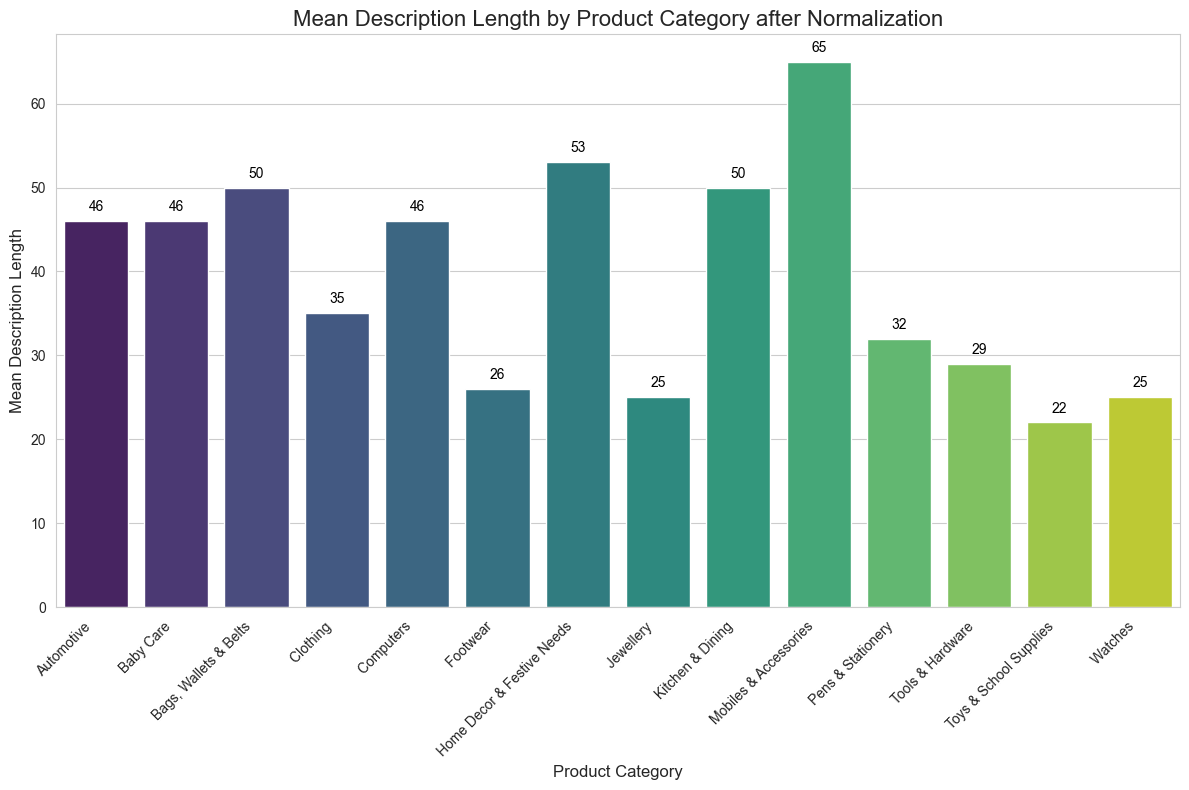

In [281]:
# Group by product_category_tree and calculate the mean length
mean_length_by_category = train_df.groupby('product_category_tree')['new_length'].mean().reset_index()

# Round the mean lengths
mean_length_by_category['new_length'] = mean_length_by_category['new_length'].round()

# Set the figure size
plt.figure(figsize=(12, 8))

# Create a bar chart
bar_plot = sns.barplot(data=mean_length_by_category, x='product_category_tree', y='new_length', palette='viridis')

# Customize the plot
plt.title('Mean Description Length by Product Category after Normalization', fontsize=16)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Mean Description Length', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Annotate the bars with mean length values
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom', fontsize=10, color='black', 
                      xytext=(0, 5),  # offset text by 5 points vertically
                      textcoords='offset points')

plt.tight_layout()  # Adjust layout

# Show the plot
plt.show()

In [285]:
print('orignal Description mean: ', train_df['length'].mean().round())
print('normalized Description mean: ', train_df['new_length'].mean().round())
print('percentage change: ',round((train_df['length'].mean()-train_df['new_length'].mean())*100/train_df['length'].mean()) )


orignal Description mean:  70.0
normalized Description mean:  36.0
percentage change:  49


**The description length is more balanced after normalization**

# 5. Train Test Split


In [262]:
# encoding target variable
category_mapping = {
    'Clothing ': 0,
    'Footwear ': 1,
    'Pens & Stationery ': 2,
    'Bags, Wallets & Belts ': 3,
    'Home Decor & Festive Needs ': 4,
    'Automotive ': 5,
    'Tools & Hardware ': 6,
    'Baby Care ': 7,
    'Mobiles & Accessories ': 8,
    'Watches ': 9,
    'Toys & School Supplies ': 10,
    'Jewellery ': 11,
    'Kitchen & Dining ': 12,
    'Computers ': 13
}
train_df['product_category_encoded'] = train_df['product_category_tree'].map(category_mapping)

In [263]:
# training data
X = train_df['clean_description']
y = train_df['product_category_encoded']

# Train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training data: " ,len(X_train), len(y_train))
print("Validation data: ",len(X_test), len(y_test))

Training data:  10530 10530
Validation data:  2633 2633


In [264]:
# for testing model on unseen data
test_df = test_product_df['description'].apply(text_normalization)

# 6. TF-IDF Vectorization

In [265]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer(ngram_range = (1, 1))

X_train_tfidf = TfidfVec.fit_transform(X_train)
X_test_tfidf = TfidfVec.transform(X_test)

test_df_tfidf = TfidfVec.transform(test_df)

# 7. Baseline Models Training

In [266]:
# importing relevant models
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier



In [267]:
# Classifiers model dictionary
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "MultinomialNB": MultinomialNB(),
    "KNN Classifier": KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
    "XGBoost": XGBClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SGD Classifier": SGDClassifier(loss='hinge'),
    "Linear SVM": svm.SVC(kernel='linear', probability=True), 
    "Ridge Classifier": RidgeClassifier(),
    "Logistic Regression": LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),
    "MLP Classifier": MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=1000)
}


In [268]:
# Function to train model and store result in a Dataframe

# Set up logging configuration
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(message)s')

def score(X_train, y_train, X_test, y_test, classifiers):
    results = []

    for name, model in classifiers.items():
        logging.info(f"Training {name}...")
        
        # Start the timer
        start_time = time.time()

        # Train the model
        model.fit(X_train, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_test)

        # Calculate accuracy
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_test, y_val_pred)

        # Calculate elapsed time
        elapsed_time = time.time() - start_time
        logging.info(f"{name} training completed in {elapsed_time:.2f} seconds.")

        # Append results
        results.append({"Classifier": name, 
                        "Training Accuracy": train_accuracy, 
                        "Validation Accuracy": val_accuracy})

    # Create DataFrame from the list of results
    score_df = pd.DataFrame(results)

    # Sort DataFrame by Validation Accuracy
    score_df.sort_values(by="Validation Accuracy", ascending=False, inplace=True)
    
    return score_df



In [269]:
# Summary of baseline models
score(X_train_tfidf, y_train, X_test_tfidf, y_test, classifiers)

INFO - Training Random Forest...
INFO - Random Forest training completed in 4.99 seconds.
INFO - Training MultinomialNB...
INFO - MultinomialNB training completed in 0.02 seconds.
INFO - Training KNN Classifier...
INFO - KNN Classifier training completed in 3.11 seconds.
INFO - Training XGBoost...
INFO - XGBoost training completed in 14.43 seconds.
INFO - Training Decision Tree...
INFO - Decision Tree training completed in 0.71 seconds.
INFO - Training AdaBoost...
INFO - AdaBoost training completed in 2.51 seconds.
INFO - Training SGD Classifier...
INFO - SGD Classifier training completed in 0.11 seconds.
INFO - Training Linear SVM...
INFO - Linear SVM training completed in 41.95 seconds.
INFO - Training Ridge Classifier...
INFO - Ridge Classifier training completed in 0.60 seconds.
INFO - Training Logistic Regression...
INFO - Logistic Regression training completed in 1.70 seconds.
INFO - Training MLP Classifier...
INFO - MLP Classifier training completed in 84.14 seconds.


,Classifier,Training Accuracy,Validation Accuracy
6,SGD Classifier,0.993257,0.979111
7,Linear SVM,0.994207,0.978352
8,Ridge Classifier,0.994872,0.977212
10,MLP Classifier,0.999335,0.976833
3,XGBoost,0.998575,0.971895
9,Logistic Regression,0.986135,0.969996
0,Random Forest,0.999335,0.969237
2,KNN Classifier,0.963533,0.954045
4,Decision Tree,0.999335,0.948728
1,MultinomialNB,0.932289,0.907710


- **SGD Classifier, Linear SVM,Ridge Classifier,  MLP Classifier are good model for categorization**
- **Tunning SGD Classifier model since it has the highest accuracy**

# 8. Hyperparameter Tunning

In [270]:
# Grid search parameters
param_grid_sgd = {
    'loss': ['hinge', 'squared_hinge', 'perceptron'], # Different loss functions
    # 'penalty': ['l2', 'l1', 'elasticnet'], #  Regularization types
    # 'alpha': [1e-3, 1e-4, 1e-5],    # Regularization strength
    'learning_rate': ['constant', 'optimal', 'adaptive'], # Learning schedules
    'eta0': [0.001, 0.01, 0.1],                 # Initial learning rate
    'max_iter': np.arange(1000, 1600, 25)       # Number of iterations
}

#  SGD Classifier gridsearchcv
grid_search_sgd = GridSearchCV(SGDClassifier(), param_grid_sgd, scoring='accuracy', cv=5, verbose=1, n_jobs=-1, return_train_score=True)
grid_search_sgd.fit(X_train_tfidf, y_train)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


GridSearchCV(cv=5, estimator=SGDClassifier(), n_jobs=-1,
             param_grid={'eta0': [0.001, 0.01, 0.1],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['hinge', 'squared_hinge', 'perceptron'],
                         'max_iter': array([1000, 1025, 1050, 1075, 1100, 1125, 1150, 1175, 1200, 1225, 1250,
       1275, 1300, 1325, 1350, 1375, 1400, 1425, 1450, 1475, 1500, 1525,
       1550, 1575])},
             return_train_score=True, scoring='accuracy', verbose=1)

In [271]:
# extract tuned model
tuned_SGD_model = grid_search_sgd.best_estimator_

# Best parameters and score
print(f"Best parameters for SGD Classifier: {grid_search_sgd.best_params_}")
print(f"Best cross-validated score: {grid_search_sgd.best_score_:.6f}")


Best parameters for SGD Classifier: {'eta0': 0.1, 'learning_rate': 'constant', 'loss': 'squared_hinge', 'max_iter': 1225}
Best cross-validated score: 0.980912


# 9. Evaluation

## 9.1 Evaluation with train dataset

Accuracy Score: 0.98

Classification Report:
                            precision    recall  f1-score   support

                Automotive       0.99      0.99      0.99       187
                 Baby Care       0.92      0.87      0.89        39
     Bags, Wallets & Belts       0.85      0.93      0.89        30
                  Clothing       0.99      1.00      1.00       933
                 Computers       0.98      0.96      0.97       106
                  Footwear       0.97      0.98      0.98       198
Home Decor & Festive Needs       0.96      0.97      0.96       121
                 Jewellery       0.99      1.00      1.00       532
          Kitchen & Dining       0.95      0.98      0.96       121
     Mobiles & Accessories       1.00      0.98      0.99       100
         Pens & Stationery       0.79      0.73      0.76        45
          Tools & Hardware       0.97      0.92      0.94        64
    Toys & School Supplies       0.88      0.83      0.85        52
  

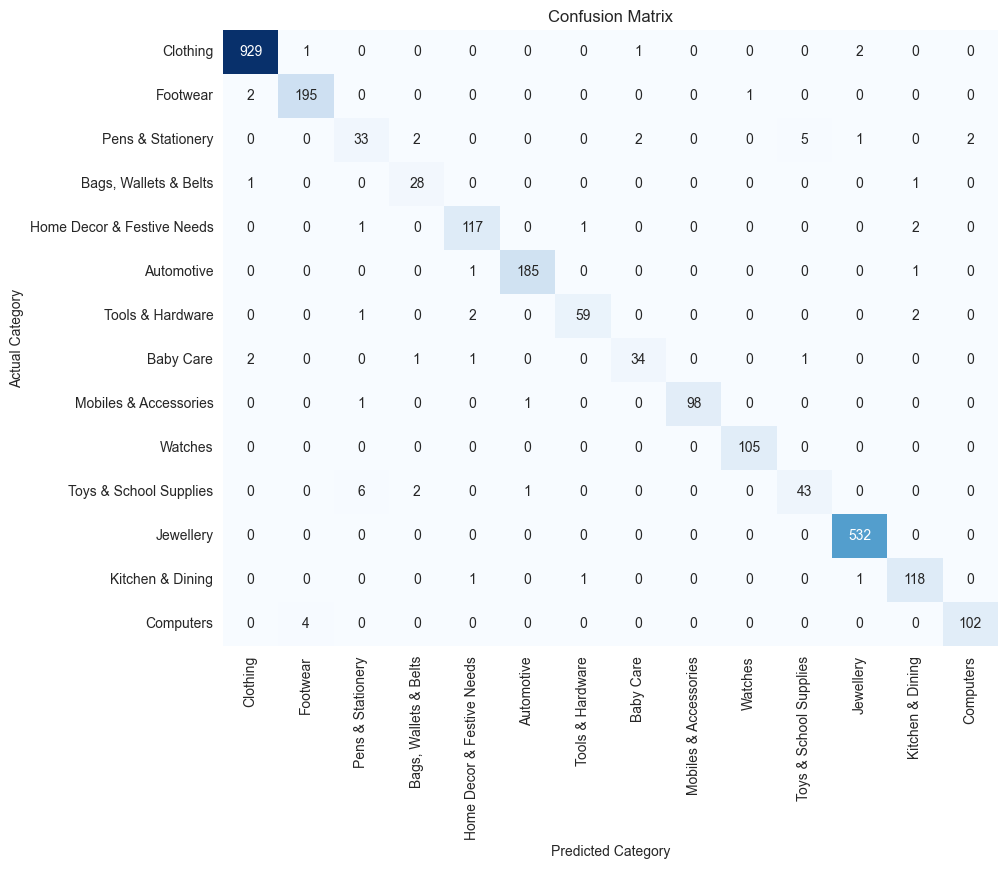

In [272]:
# Reverse mapping from encoded labels to original category names
reverse_category_mapping = {v: k.strip() for k, v in category_mapping.items()}

# Fit the model
tuned_SGD_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_encoded = tuned_SGD_model.predict(X_test_tfidf)

# Decode the predicted labels and true labels
y_pred_decoded = [reverse_category_mapping[label] for label in y_pred_encoded]
y_test_decoded = [reverse_category_mapping[label] for label in y_test]

# Accuracy Score
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Accuracy Score: {accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_decoded, y_pred_decoded))

# Confusion Matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=list(reverse_category_mapping.values()))

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=list(reverse_category_mapping.values()), 
            yticklabels=list(reverse_category_mapping.values()))
plt.title('Confusion Matrix')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


## 9.2 Evaluation with Test dataset

In [273]:
# importing given test result
test_result = pd.read_csv("Datasets/test_results.csv")

# encoding labels 
y_test = test_result['product_category_tree'].map(category_mapping)

# converting datatype to numpy array
y_test = np.array(y_test)

In [274]:
# making prediction on the test data
y_test_pred = tuned_SGD_model.predict(test_df_tfidf)

# calculating accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on given Test Data: {accuracy:.4f}")

Accuracy on given Test Data: 0.8548


# 9.3 Saving models

In [275]:
import joblib

# Save the model
joblib.dump(tuned_SGD_model, 'models/tuned_SGD_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(TfidfVec, 'models/tfidf_vectorizer.pkl')

['models/tfidf_vectorizer.pkl']

# 10. conclusion

In conclusion, the machine learning model developed for predicting product categories has demonstrated remarkable accuracy, achieving an accuracy score of **0.98**. The classification report highlights the model's strong performance across various categories, particularly in **Automotive**, **Clothing**, and **Jewellery**, where precision and recall metrics are exceptionally high. This indicates that the model is effective in correctly identifying products within these categories while minimizing false positives and negatives.

Overall, the results of this project underscore the potential of machine learning in enhancing product classification tasks in e-commerce settings. By automating this process, businesses can streamline their operations, improve customer experiences, and ultimately drive sales.

Future work could involve further fine-tuning the model and exploring additional features to enhance its predictive capabilities.
